In [1]:
%matplotlib inline

import configparser
import os

import requests
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse, stats, spatial
import scipy.sparse.linalg
from sklearn import preprocessing, decomposition
import librosa
import IPython.display as ipd
import json
import tmdbsimple as tmdb
from itertools import chain
from pygsp import graphs, filters, plotting

plt.rcParams['figure.figsize'] = (17, 5)
plotting.BACKEND = 'matplotlib'

In [172]:
dataset = pd.read_csv('Saved_Datasets/NewFeaturesDataset.csv')

In [173]:
dataset.head(10)

,id,budget,genres,imdb_id,overview,production_companies,release_date,revenue,tagline,title,director_name,director_id,actor_names,actor_ids,Metacritic,Normed_Metacritic,ROI,Normed_ROI,success
0,12,94000000,Animation|Family,266543,"Nemo, an adventurous young clownfish, is unexp...",Pixar Animation Studios,2003-05-30,940335536,"There are 3.7 trillion fish in the ocean, they...",Finding Nemo,Andrew Stanton,0,"['Albert Brooks', 'Ellen DeGeneres', 'Alexande...","[0, 908, 2000, 772, 3304]",90,0.943,9.003570,0.47,1
1,16,12800000,Drama|Crime|Music,168629,"Selma, a Czech immigrant on the verge of blind...",Fine Line Features,2000-05-17,40031879,You don't need eyes to see.,Dancer in the Dark,Lars von Trier,1,"['Björk', 'Catherine Deneuve', 'David Morse', ...","[1, 434, 2001, 1630, 3993]",61,0.731,2.127491,0.14,1
2,22,140000000,Adventure|Fantasy|Action,325980,"Jack Sparrow, a freewheeling 17th-century pira...",Walt Disney Pictures,2003-09-07,655011224,Prepare to be blown out of the water.,Pirates of the Caribbean: The Curse of the Bla...,Gore Verbinski,2,"['Johnny Depp', 'Geoffrey Rush', 'Orlando Bloo...","[2, 412, 136, 71, 3143]",63,0.754,3.678652,0.23,1
3,24,30000000,Action|Crime,266697,An assassin is shot at the altar by her ruthle...,Miramax Films,2003-10-10,180949000,Go for the kill.,Kill Bill: Vol. 1,Quentin Tarantino,3,"['Uma Thurman', 'Lucy Liu', 'Vivica A. Fox', '...","[3, 1071, 2002, 1684, 1097]",69,0.814,5.031633,0.30,1
4,25,72000000,Drama|War,418763,Jarhead is a film about a US Marine Anthony Sw...,Universal Pictures,2005-04-11,96889998,Welcome to the suck.,Jarhead,Sam Mendes,4,"['Jamie Foxx', 'Scott MacDonald', 'Lucas Black...","[4, 1072, 328, 1293]",58,0.695,0.345694,0.02,1
5,27,1000000,Drama|Music|Romance,411705,"Matt, a young glaciologist, soars across the v...",Revolution Films,2004-07-16,1574623,"2 lovers, one summer, and the 9 songs that def...",9 Songs,Michael Winterbottom,5,"[""Kieran O'Brien"", 'Margo Stilley', 'Courtney ...","[5, 1073, 2003, 2983, 3994]",43,0.480,0.574623,0.04,1
6,35,75000000,Animation|Comedy|Family,462538,After Homer accidentally pollutes the town's w...,Gracie Films,2007-07-25,527068851,See our family. And feel better about yours.,The Simpsons Movie,David Silverman,6,"['Dan Castellaneta', 'Julie Kavner', 'Nancy Ca...","[6, 1074, 2004, 2984, 719]",80,0.896,6.027585,0.34,1
7,38,20000000,Science Fiction|Drama|Romance,338013,"Joel Barish, heartbroken that his girlfriend u...",Anonymous Content,2004-03-19,72258126,You can erase someone from your mind. Getting ...,Eternal Sunshine of the Spotless Mind,Michel Gondry,7,"['Jim Carrey', 'Kate Winslet', 'Kirsten Dunst'...","[7, 131, 147, 652, 20]",89,0.939,2.612906,0.17,1
8,58,200000000,Adventure|Fantasy|Action,383574,Captain Jack Sparrow works his way out of a bl...,Walt Disney Pictures,2006-06-20,1065659812,Jack is back!,Pirates of the Caribbean: Dead Man's Chest,Gore Verbinski,2,"['Johnny Depp', 'Orlando Bloom', 'Keira Knight...","[2, 136, 71, 421, 472]",53,0.629,4.328299,0.26,1
9,59,32000000,Drama|Thriller|Crime,399146,An average family is thrust into the spotlight...,New Line Cinema,2005-09-23,60740827,Tom Stall had the perfect life... until he bec...,A History of Violence,David Cronenberg,8,"['Viggo Mortensen', 'Maria Bello', 'Heidi Haye...","[8, 1075, 2005, 2985, 636]",81,0.901,0.898151,0.06,1


## 1. Data exploration ###

In [174]:
#number of movies per directors
all_director = list(dataset['director_name'])
print(len(all_director))
diff_all_director = list(set(all_director))
print(len(diff_all_director))
#print(diff_all_director)

freqDir = []
for i in diff_all_director:
    freqDir.append(all_director.count(i))
#print(freqDir)    

#distribution nb movies per director
movies_per_dir = []
diff_freq = list(set(freqDir))
print(diff_freq)
for i in diff_freq:
    movies_per_dir.append(freqDir.count(i))
print(movies_per_dir)    

2621
1294
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14]
[742, 237, 131, 73, 46, 26, 14, 11, 6, 3, 3, 2]


In [175]:
moy = ((np.array(movies_per_dir) @ np.array(diff_freq)))/(len(diff_all_director))
print(moy)

2.02550231839


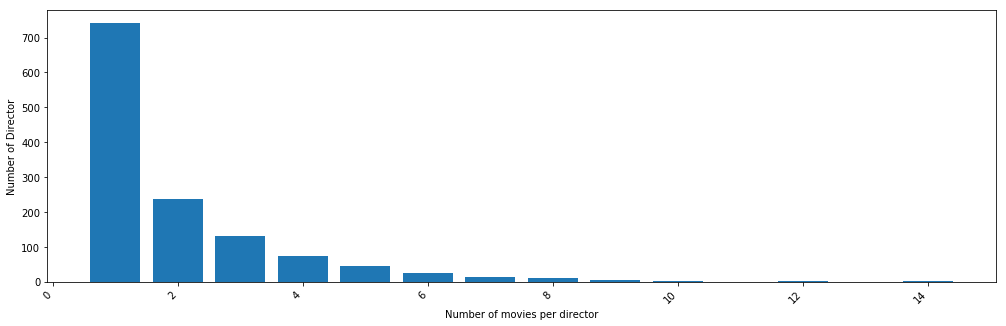

In [176]:
plt.bar(diff_freq, movies_per_dir, align='center');
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right');
plt.xlabel('Number of movies per director');
plt.ylabel('Number of Director');
plt.savefig('images/nb_movie_per_dir.png', dpi=300, bbox_inches='tight')

In [178]:
top_director = {}

for j in diff_freq[6:]:
    dir_name_top = []
    for i in range(0,len(freqDir)):
        if freqDir[i] == j:
            dir_name_top.append(diff_all_director[i])
    top_director[j] = dir_name_top

print(top_director)
        

{7: ['Kevin Smith', 'James Wan', 'Louis Leterrier', 'Danny Boyle', 'Martin Scorsese', 'Tim Story', 'Robert Luketic', 'Rob Cohen', 'Zack Snyder', 'Bryan Singer', 'Renny Harlin', 'Brett Ratner', 'Lasse Hallström', 'Dennis Dugan'], 8: ['Jon Favreau', 'Robert Zemeckis', 'Adam Shankman', 'Peter Jackson', 'Roland Emmerich', 'Gore Verbinski', 'Christopher Nolan', 'M. Night Shyamalan', 'Marc Forster', 'Peter Berg', 'Paul W.S. Anderson'], 9: ['Antoine Fuqua', 'Bobby Farrelly', 'Michael Bay', 'Todd Phillips', 'Ron Howard', 'Richard Linklater'], 10: ['Tim Burton', 'Woody Allen', 'Shawn Levy'], 12: ['Robert Rodriguez', 'Steven Spielberg', 'Ridley Scott'], 14: ['Clint Eastwood', 'Steven Soderbergh']}


## 2.  Director similartiy between pairs of movies

In [179]:
director_list = list(set(dataset['director_id']))
nb_directors = len(director_list)

director_dic = {}
for i in range(0,len(dataset)):
    director_dic[i]=dataset['director_id'][i]
print(director_dic)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 2, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 22, 25: 22, 26: 23, 27: 24, 28: 25, 29: 26, 30: 14, 31: 27, 32: 27, 33: 28, 34: 29, 35: 30, 36: 31, 37: 13, 38: 27, 39: 32, 40: 33, 41: 33, 42: 34, 43: 35, 44: 36, 45: 36, 46: 13, 47: 37, 48: 38, 49: 39, 50: 40, 51: 22, 52: 41, 53: 14, 54: 42, 55: 2, 56: 7, 57: 43, 58: 27, 59: 44, 60: 45, 61: 46, 62: 47, 63: 48, 64: 14, 65: 49, 66: 11, 67: 50, 68: 51, 69: 52, 70: 53, 71: 54, 72: 55, 73: 3, 74: 56, 75: 57, 76: 58, 77: 59, 78: 60, 79: 41, 80: 61, 81: 62, 82: 63, 83: 7, 84: 64, 85: 65, 86: 27, 87: 66, 88: 67, 89: 68, 90: 69, 91: 70, 92: 71, 93: 20, 94: 72, 95: 73, 96: 74, 97: 75, 98: 75, 99: 75, 100: 76, 101: 2, 102: 67, 103: 77, 104: 21, 105: 78, 106: 12, 107: 64, 108: 13, 109: 79, 110: 79, 111: 80, 112: 13, 113: 81, 114: 82, 115: 83, 116: 13, 117: 84, 118: 13, 119: 69, 120: 36, 121: 85, 122: 86, 123: 87, 124: 88, 

In [180]:

directorArray = np.ndarray(shape=(len(dataset), nb_directors), dtype=int)
for i in range(0, len(dataset)):
    #genreDict.setdefault(i, [])
    
    vector = np.zeros(nb_directors)
    
    #add vectors of 1's and 0's to obtain vector of genres
    vector += (director_dic[i] == np.array(director_list)).astype(int)
    
    #genreDict[i].append(vector)
    directorArray[i] = vector

In [181]:
print(len(directorArray[0]))
print(directorArray.size)

1294
3391574


In [182]:
Directors = pd.DataFrame(directorArray, columns=director_list)
Directors.head(10)

,0,1,2,3,4,5,6,7,8,9,...,1390,1391,1392,1393,1394,1396,1399,1401,1403,1405
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Weight matrix computation

In [189]:
W = np.dot(directorArray,np.transpose(directorArray))

In [190]:
np.fill_diagonal(W, 0)

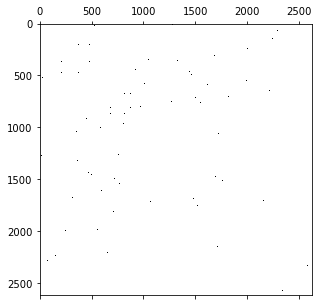

In [191]:
plt.spy(W)

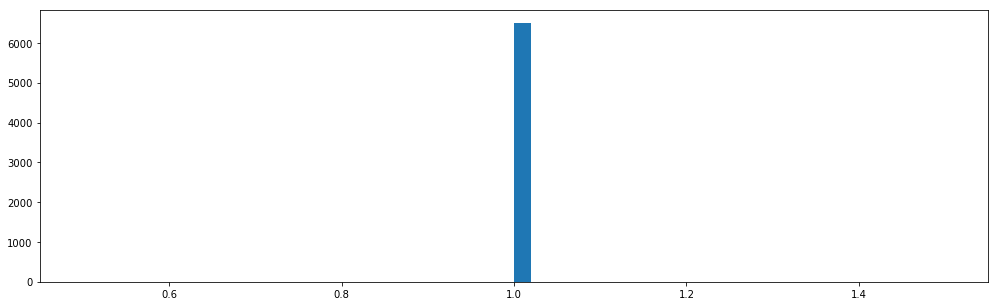

In [192]:
plt.hist(W[W > 0].reshape(-1), bins=50);

In [193]:
print('There are {} edges equal to zero '.format(np.sum(W == 0)/2))
print('There are {} edges equal to one '.format(np.sum(W == 1)/2))

There are 3431569.5 edges equal to zero 
There are 3251.0 edges equal to one 


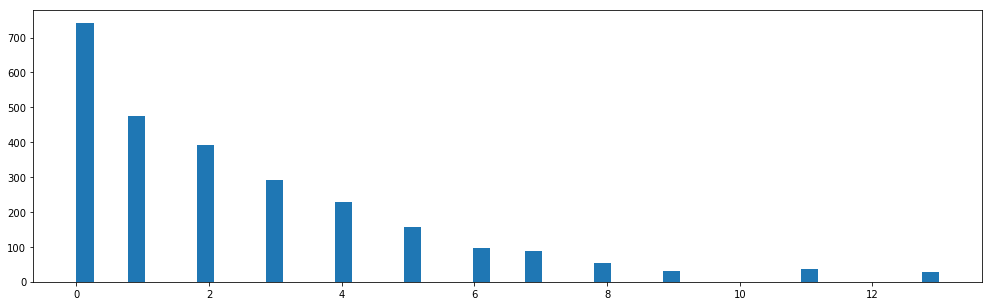

In [194]:
#Compute degree distribution 
degrees = np.zeros(len(W)) 
for i in range(0, len(W)):
    degrees[i] = sum(W[i])

plt.hist(degrees, bins=50);

In [195]:
NormW = pd.DataFrame(W)
NormW.head()

,0,1,2,3,4,5,6,7,8,9,...,2611,2612,2613,2614,2615,2616,2617,2618,2619,2620
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
W.to_csv('Saved_Datasets/NormalizedDirectorW.csv', index=False)

### 3. Similartiy between number of movies per director###

In [39]:
#Apply nb movie per director to the dataset
mov_per_dir_dataset = []
for i in range(0,len(dataset['director_name'])):
    for j in range(0,len(diff_all_director)):
        if dataset['director_name'][i] == diff_all_director[j]:
            mov_per_dir_dataset.append(freqDir[j])
            

In [83]:
#W = np.ndarray(shape=(10, 10), dtype=int)
W_diff = np.zeros(shape=(len(dataset), len(dataset)), dtype=int)
for i in range(0,len(dataset)):
    for j in range(i,len(dataset)):
        W_diff[i][j] = abs(mov_per_dir_dataset[i]-mov_per_dir_dataset[j])

In [84]:
print(W_diff)

[[0 2 5 ..., 2 1 2]
 [0 0 7 ..., 0 1 0]
 [0 0 0 ..., 7 6 7]
 ..., 
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 0]]


In [85]:
bigger = W_diff.transpose() > W_diff
W_diff = W_diff - W_diff*bigger + W_diff.transpose()*bigger
np.fill_diagonal(W_diff, 0)

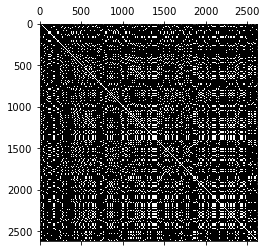

In [86]:
plt.spy(W_diff)

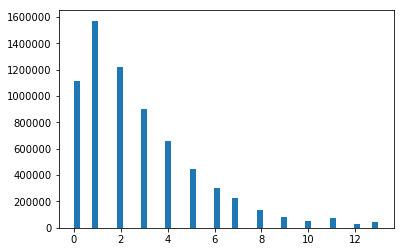

In [101]:
plt.hist(W_diff.reshape(-1),bins=50);

#### Weights normalization ####

In [1]:
val_75 = np.percentile(W_diff,75)
print(val_75)

NameError: name 'np' is not defined

In [136]:
W_diff_norm = np.zeros(shape=(len(dataset), len(dataset)), dtype=float)
for i in range(0,len(dataset)):
    for j in range(i,len(dataset)):
        if W_diff[i][j] == 0:
            W_diff_norm[i][j] = 1
        elif W_diff[i][j] <= 4:  
            W_diff_norm[i][j] = 1-(W_diff[i][j])/(val_75)
        else:
            W_diff_norm[i][j] = 0

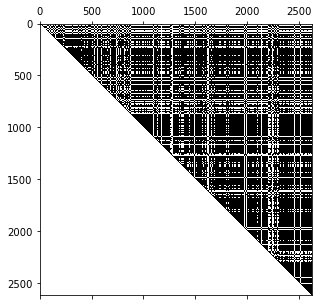

In [137]:
plt.spy(W_diff_norm)

In [138]:
bigger = W_diff_norm.transpose() > W_diff_norm
W_diff_norm = W_diff_norm - W_diff_norm*bigger + W_diff_norm.transpose()*bigger
np.fill_diagonal(W_diff_norm, 0)

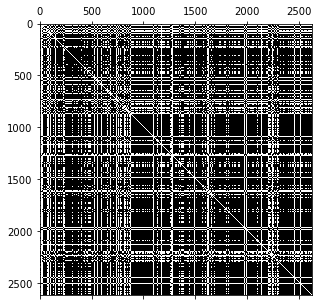

In [139]:
plt.spy(W_diff_norm)

In [166]:
DiffNormW = pd.DataFrame(W_diff_norm)
DiffNormW.head()

,0,1,2,3,4,5,6,7,8,9,...,2611,2612,2613,2614,2615,2616,2617,2618,2619,2620
0,0.00,0.5,0.00,0.50,0.25,0.75,0.5,0.75,0.00,0.75,...,0.75,0.5,0.00,1.00,0.5,0.75,0.5,0.5,0.75,0.5
1,0.50,0.0,0.00,0.00,0.00,0.75,1.0,0.25,0.00,0.25,...,0.75,1.0,0.00,0.50,1.0,0.75,1.0,1.0,0.75,1.0
2,0.00,0.0,0.00,0.25,0.50,0.00,0.0,0.00,1.00,0.00,...,0.00,0.0,1.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0
3,0.50,0.0,0.25,0.00,0.75,0.25,0.0,0.75,0.25,0.75,...,0.25,0.0,0.25,0.50,0.0,0.25,0.0,0.0,0.25,0.0
4,0.25,0.0,0.50,0.75,0.00,0.00,0.0,0.50,0.50,0.50,...,0.00,0.0,0.50,0.25,0.0,0.00,0.0,0.0,0.00,0.0


In [167]:
DiffNormW.to_csv('Saved_Datasets/DiffNormDirW.csv', index=False)

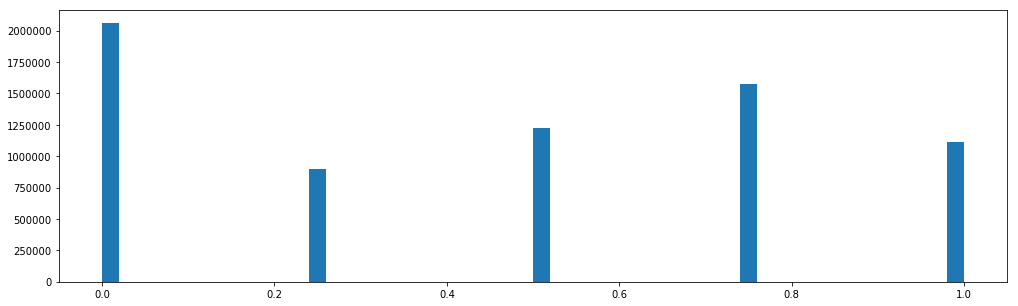

In [140]:
plt.hist(W_diff_norm.reshape(-1),bins=50);

In [141]:
G = graphs.Graph(W_diff_norm)
G.compute_laplacian('normalized')

In [134]:
len(W_diff_norm)

2621

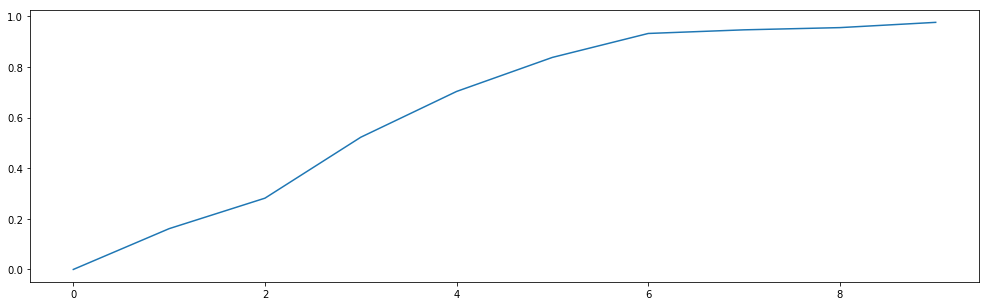

In [142]:
G.compute_fourier_basis(recompute=True)
plt.plot(G.e[0:10]);

In [152]:
genres = preprocessing.LabelEncoder().fit_transform(dataset['success'])
G.set_coordinates(G.U[:,1:3])

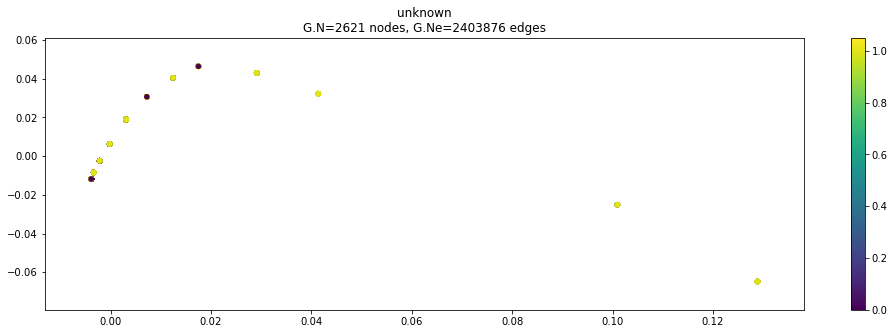

In [148]:
G.plot_signal(genres, vertex_size=20)

In [153]:
NEIGHBORS = 300

#sort the order of the weights
sort_order = np.argsort(W_diff_norm, axis = 1)

#declaration of a sorted weight matrix
sorted_weights = np.zeros((len(W_diff_norm), len(W_diff_norm)))

for i in range (0, len(W_diff_norm)):  
    for j in range(0, len(W_diff_norm)):
        if (j >= len(W_diff_norm) - NEIGHBORS):
            #copy the k strongest edges for each node
            sorted_weights[i, sort_order[i,j]] = W_diff_norm[i,sort_order[i,j]]
        else:
            #set the other edges to zero
            sorted_weights[i, sort_order[i,j]] = 0

#ensure the matrix is symmetric
bigger = sorted_weights.transpose() > sorted_weights
sorted_weights = sorted_weights - sorted_weights*bigger + sorted_weights.transpose()*bigger

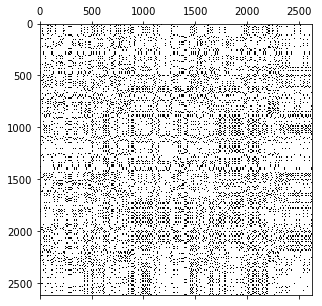

In [154]:
plt.spy(sorted_weights)

In [155]:
G_s = graphs.Graph(sorted_weights)
G_s.compute_laplacian('normalized')

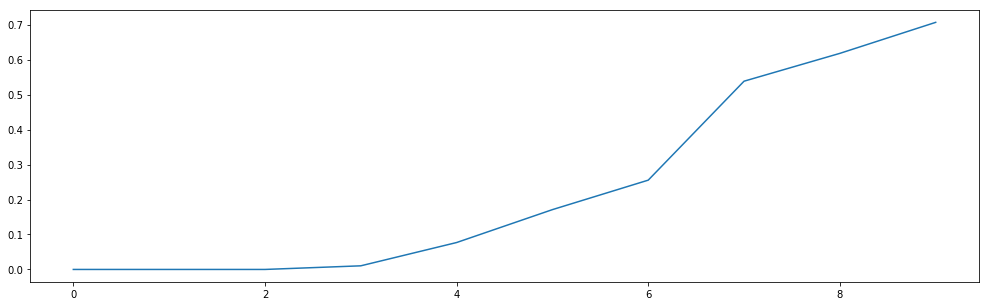

In [156]:
G_s.compute_fourier_basis(recompute=True)
plt.plot(G_s.e[0:10]);

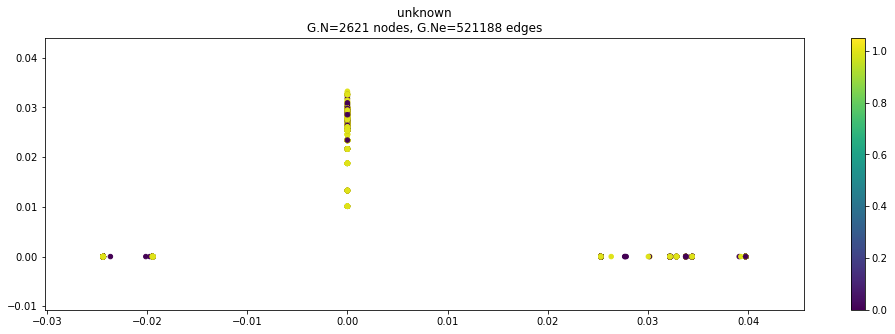

In [160]:
G_s.set_coordinates(G_s.U[:,1:3])
G_s.plot_signal(genres, vertex_size=20)

In [161]:
labels_reg = preprocessing.LabelEncoder().fit_transform(dataset['Normed_ROI'])

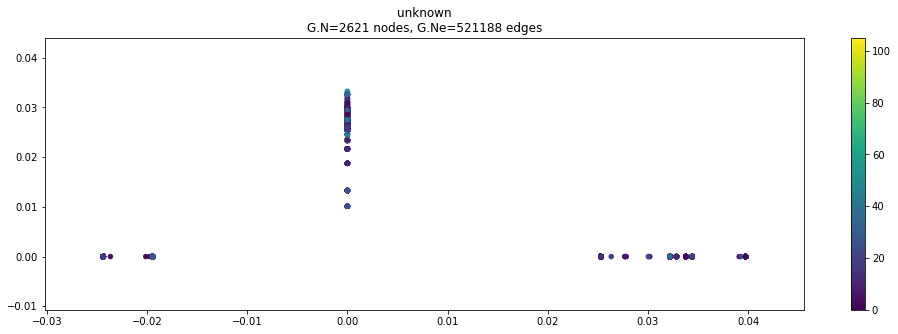

In [163]:
G_s.plot_signal(labels_reg, vertex_size=20)